# Tasks:
    - analyze article-category tag
    - section/paragraph/sentence boundries
    - how does table/graph represeted in the paragraph

In [1]:
# !pip install BeautifulSoup4
# !pip install lxml

In [71]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=80, edgeitems=50)
from bs4 import BeautifulSoup
import time
import json
import requests
from urllib.request import urlopen
from fastprogress.fastprogress import master_bar, progress_bar
from concurrent.futures import ThreadPoolExecutor
import threading
import collections
import codecs

# Metadata: article-category

In [57]:
base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
search_url = "esearch.fcgi?db=pmc&term="
fetch_url = "efetch.fcgi?db=pmc&id="

all_categories = []

In [35]:
def get_article_category(pmc_id):
    #pmc_id = "7243836"
    target_url = base_url + fetch_url + pmc_id
    page = urlopen(target_url)
    soup = BeautifulSoup(page, "xml")
    article_category = soup.find('article-categories')
    article_subject = article_category.find('subject')
    all_categories.append(article_subject.text)
    time.sleep(1)
    

In [36]:
# read in the related_paper pmc list
ids = []
f = open("./pmc_list.txt", "r")
f1 = f.readlines()
for x in f1:
    ids.append(x)

In [37]:
len(ids)

79006

In [38]:
def num_cpus():
    try:
        return len(os.sched_getaffinity(0))
    except AttributeError:
        return os.cpu_count()
num_cpus()

4

In [39]:
# parsing the first 2000 related papers
start = time.time()
# with ThreadPoolExecutor(max_workers=num_cpus()//2) as executor:
with ThreadPoolExecutor(max_workers=3) as executor:
    results = executor.map(get_article_category, ids[:2000])
    # jobs = (executor.submit(process, chunk) for chunk in df_generator)
print('Total time taken: {}'.format(time.time() - start))

Total time taken: 815.6444630622864


In [51]:
counter = collections.Counter(all_categories)
counter

Counter({'Article': 802,
         'Editorial': 61,
         'Review Article': 26,
         'Special Section Article': 4,
         'Systematic Review': 4,
         'Letter To The Editor': 3,
         'Commentary': 42,
         'Medical Education Adaptations': 2,
         'Short Communication': 8,
         'Crisis Management': 2,
         'Behavioral-Bio-Medical Interface (RJ DiClemente and JL Brown, Section Editors)': 1,
         'Research': 46,
         'Research Article': 131,
         'Study Protocol': 22,
         'Original Article': 73,
         'Review': 65,
         'Opinion': 3,
         'Perspectives': 3,
         'Meeting Abstracts': 4,
         'News & Views': 1,
         'Special Features': 2,
         'Rapid Communication': 3,
         'Letters to the Editor': 3,
         'Business of Urology': 1,
         'Supplemental Issue Article': 1,
         'Original Paper': 91,
         'Feminist Frontiers': 1,
         'Nyasbiol3577': 1,
         'Research: Educational and Psycholo

In [45]:
def article_category_distribution(y):

    N = len(np.unique(y))
    menMeans = pd.get_dummies(y).sum(axis=0).sort_values(ascending=False).values
    ind = np.arange(N)    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence
    p1 = plt.bar(ind, menMeans, width)
    plt.ylabel('category count')
    plt.xlabel('categories')
    plt.title('category distribution')
    #plt.xticks(ind, pd.get_dummies(y).sum(axis=0).sort_values(ascending=False).keys())
    plt.show()

Taking a look at the distribution fo all article categories, it is highly skewed

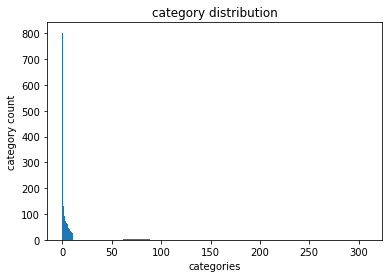

In [48]:
article_category_distribution(np.array(all_categories))

In [53]:
counter.most_common(20)

[('Article', 802),
 ('Research Article', 131),
 ('Original Paper', 91),
 ('Original Article', 73),
 ('Review', 65),
 ('Editorial', 61),
 ('Research', 46),
 ('Commentary', 42),
 ('Original Research', 36),
 ('Articles', 32),
 ('Review Article', 26),
 ('Letter to the Editor', 25),
 ('Study Protocol', 22),
 ('Public Health', 20),
 ('Correspondence', 14),
 ('Special Issue', 13),
 ('Perspective', 12),
 ('Original Articles', 12),
 ('Protocol', 11),
 ('Notes From The Field', 9)]

Among the 2000 samples articles, the majority categories are "Article" and "Research Article". 

# section/paragraph boundry

Sample query: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pmc&id=7225297

### One way to extract all the text from a page:

In [58]:
def get_article(pmc_id):
    #pmc_id = "7243836"
    target_url = base_url + fetch_url + pmc_id
    page = urlopen(target_url)
    soup = BeautifulSoup(page, "xml")
    return soup


In [59]:
soup = get_article("7225297")

In [79]:
# get text form of everything in the xml file
soup.get_text()

"\n\n\n\nFront Pediatr\nFront Pediatr\nFront. Pediatr.\n\nFrontiers in Pediatrics\n\n2296-2360\n\nFrontiers Media S.A.\n\n\n\n32457859\n7225297\n10.3389/fped.2020.00207\n\n\nPediatrics\n\nPerspective\n\n\n\n\nA Perspective on Management of Limb Fractures in Obese Children: Is It Time for Dedicated Guidelines?\n\n\n\n\nDonati\nFabrizio\n\n\n1\n\n\n\n\n\nCostici\nPier Francesco\n\n\n1\n\n\n\n\nDe Salvatore\nSergio\n\n\n2\n\n\n\n\n\nBurrofato\nAaron\n\n\n1\n\n\n\n\nMicciulli\nEnrico\n\n\n1\n\n\n\n\nMaiese\nAniello\n\n\n3\n\n\n*\n\n\n\n\n\nSantoro\nPaola\n\n\n3\n\n\n\n\n\nLa Russa\nRaffaele\n\n\n3\n\n\n\n\n1Department of General Surgery, Orthopedic Institute, Bambino Gesù Children Hospital, Rome, Italy\n2Department of Orthopaedic and Trauma Surgery, Campus Bio-Medico University of Rome, Rome, Italy\n3Department of Anatomical, Histological, Forensic and Orthopaedic Sciences, Sapienza University of Rome, Rome, Italy\n\n\nEdited by: Marzia Duse, Sapienza University of Rome, Italy\n\n\nReviewe

The most identifiable boundries are:
    - sectionss are seperated mostly by "\n\n\n", there are cases seprated by "\n\n\n\n"
    - paragraphs are seperated mostly by "\n", there are cases seprated by "\n\n"
Pro:

    1) we have a relatively comprehensive txt file

Con:

    1) I found that other publishers have differet indentation styles using "\n", it might be difficulte to summarize at this point

    2) Figures and tables are hard to identify, the only indicator is the via the text "Table" or "Figure", this is not a problem if we have the xml file

### Another way:  extracting from the given tag

#### by section

In [81]:
paper_id = "7225297"
contrib = soup.find('body')
sections = contrib.find_all('sec')

# save each section to txt file
with codecs.open('./full_content/{}_paper_by_section.txt'.format(paper_id), 'wb', encoding='utf-8') as file:
    for s in sections:
        print(s.text)
        file.write(s.text)
file.close()



Introduction
Limb fractures are the most common injuries in pediatric orthopedics. Early and late complications are often not preventable, even when providing the best treatment; furthermore, these illnesses are often implicated in medico-legal claims. The development of evidence-based guidelines (EBG) is one of the main goals of medical research. Approved guidelines are fundamental to improve medical practice, especially in the management of specific diseases. The quality of guidelines strictly relies on the strength of its scientific evidence, which is often insufficient in pediatric orthopedic publications (1). A wide standardization of treatment is not always possible in medicine since specific conditions often require adjustments to the normal standard of care. One of these conditions is pediatric obesity (defined as a Body Mass Index, BMI, at or above the 95th percentile for children and teens of the same age and sex). Both obesity and polytrauma are major health problems. Despi

#### by paragraph

In [78]:
paper_id = "7225297"
contrib = soup.find('body')
paragraphs = contrib.find_all('p')

# save each section to txt file
with codecs.open('./full_content/{}_paper_by_paragraph.txt'.format(paper_id), 'wb', encoding='utf-8') as file:
    for p in paragraphs:
        print(p.text)
        file.write(p.text)
        file.write("\n\n")
file.close()
        

Limb fractures are the most common injuries in pediatric orthopedics. Early and late complications are often not preventable, even when providing the best treatment; furthermore, these illnesses are often implicated in medico-legal claims. The development of evidence-based guidelines (EBG) is one of the main goals of medical research. Approved guidelines are fundamental to improve medical practice, especially in the management of specific diseases. The quality of guidelines strictly relies on the strength of its scientific evidence, which is often insufficient in pediatric orthopedic publications (1). A wide standardization of treatment is not always possible in medicine since specific conditions often require adjustments to the normal standard of care. One of these conditions is pediatric obesity (defined as a Body Mass Index, BMI, at or above the 95th percentile for children and teens of the same age and sex). Both obesity and polytrauma are major health problems. Despite rate of tra

Using this method, we are able to seperatey sections/paragraph in a more clear way. However, tables and figures are still only be identified by looking for target words, eg "Table", "Figure"